In [24]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast
import os

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from collections import defaultdict


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


Loading BokehJS ...

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


In [2]:
filepath ='data/selected/'
filelist = os.listdir(filepath)
print(filelist)
len(filelist)

['heat recovery-selected.csv', 'green energy-selected.csv', 'wastewater treatment-selected.csv', 'maritime electrification-selected.csv', 'clean technology-selected.csv', 'waste reduction-selected.csv', 'green building-selected.csv', 'carbon emissions-selected.csv', 'renewable energy-selected.csv', 'smart home-selected.csv', 'additive manufacturing-selected.csv', 'energy efficient-selected.csv', 'geothermal-selected.csv', 'clean-energy-selected.csv', 'energy storage-selected.csv']


15

In [3]:
selected_df = pd.DataFrame()
for filename in filelist:
    raw_data = pd.read_csv(filepath + filename)
    num = len(raw_data.query("`affiliation-country` == 'New Zealand'"))
    try:
        NZ_Data = raw_data.query("`affiliation-country` == 'New Zealand'")
        US_data = raw_data.query("`affiliation-country` == 'United States'").sample(n = num,random_state=1)
        UK_data = raw_data.query("`affiliation-country` == 'United Kingdom'").sample(n = num,random_state=1)
        CH_data = raw_data.query("`affiliation-country` == 'China'").sample(n = num,random_state=1)
        AU_data = raw_data.query("`affiliation-country` == 'Austria'").sample(n = num,random_state=1)
    except: pass
    raw_data_selected = pd.concat([NZ_Data,CH_data,US_data,UK_data,AU_data])
    selected_df = pd.concat([selected_df,raw_data_selected])



In [4]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)
# Define helper functions
def get_top_n_words_topic_model(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        # print('hello {}'.format(temp_vector_sum))
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [5]:
reindexed_data = selected_df['abstract']
reindexed_data.index = selected_df.index
reindexed_data.head()

26      Latent heat storage is one of the most efficie...
137     Energy storage in the walls, ceiling and floor...
624     This review reveals that crop residues of comm...
1046    Current health services are struggling to prov...
1778    Computer modeling of geothermal systems has be...
Name: abstract, dtype: object

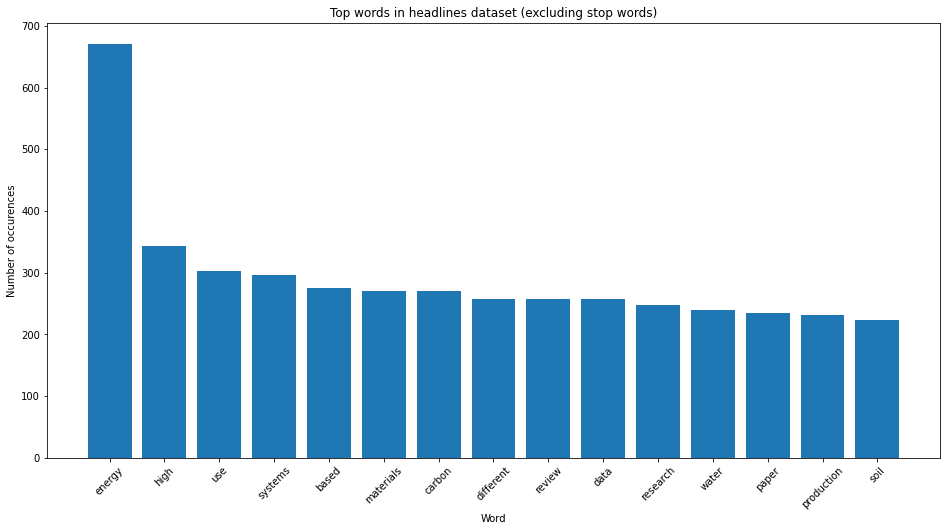

In [6]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation=45);
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [7]:
n_topics = 12
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = reindexed_data.values
small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

In [8]:
# LDA
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [9]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [17]:
top_n_words_lda = get_top_n_words_topic_model(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  moment unsteady responses bending blade forcing tidal fatigue turbine flow
Topic 2:  soil gas methane effects coal reservoir permeability management species energy
Topic 3:  storage heat phase thermal change applications energy large pcms materials
Topic 4:  high water properties temperature carbon low using conditions surface range
Topic 5:  surface surfaces review evidence scale fe3o4 phase iron mechanisms different
Topic 6:  crop fuels biodiesel oil crops residues management renewable transport soil
Topic 7:  fuels algal production china orogenic oil algae term commercialization deposits
Topic 8:  ar magmatism rhyolitic microplastic ca using magma erupted ash cleansers
Topic 9:  energy materials high properties solar storage membrane systems review discussed
Topic 10:  nutrients nutrient ca excreted animal pasture caldera collapse urine intrusions
Topic 11:  eruptions valanginian eruption age magma zone upper hauterivian diatreme volcanic
Topic 12:  energy use systems emis

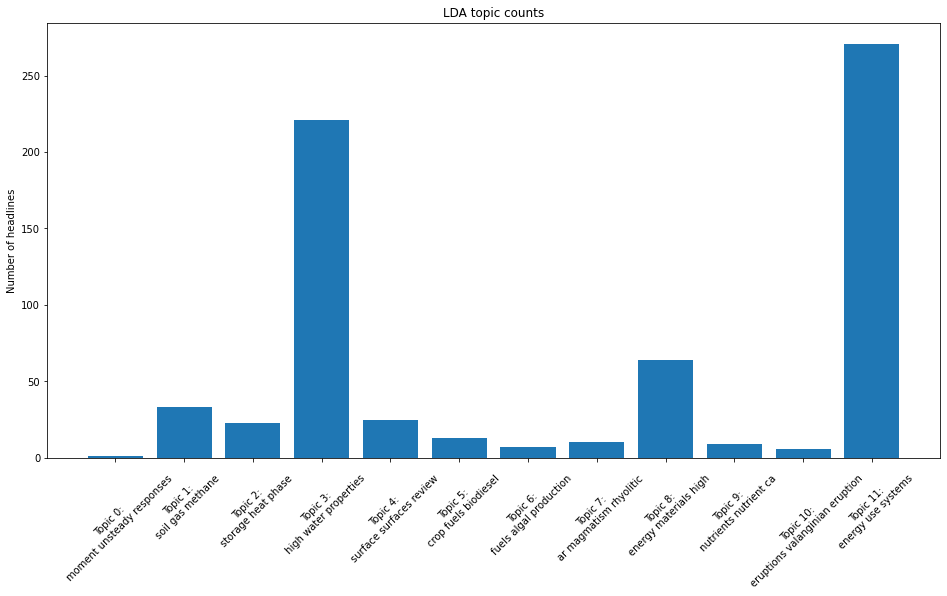

In [15]:
top_3_words = get_top_n_words_topic_model(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels,rotation = 45);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of headlines');

In [12]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
docs_raw = raw_data.abstract
dtm_tf = tf_vectorizer.fit_transform(docs_raw)
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:2019: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn(


In [13]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tf.fit(dtm_tf)
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=20, random_state=0)

In [14]:
panel = pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)
pyLDAvis.display(panel)
pyLDAvis.save_html(panel,"mutil_lda_result.html")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pa

In [28]:
# Get Country Rank under each topic.
topic_words=[]
for topic in top_n_words_lda:
    topic_word = topic.split(" ")
    topic_words.append(topic_word)
# print(topic_words)

abstracts = selected_df.abstract.values.tolist()

print(abstracts[0:5])

threshold = 4
for topic in topic_word:
    country_dict  = defaultdict(int)

    for abstract in abstracts:
        flag = 0
        words = abstract.split(" ")
        for top_word in topic:
            if top_word in words:
                flag +=1
            if flag>=threshold:
                country_dict[]
                break
    



['Latent heat storage is one of the most efficient ways of storing thermal energy. Unlike the sensible heat storage method, the latent heat storage method provides much higher storage density, with a smaller temperature difference between storing and releasing heat. This paper reviews previous work on latent heat storage and provides an insight to recent efforts to develop new classes of phase change materials (PCMs) for use in energy storage. Three aspects have been the focus of this review: PCM materials, encapsulation and applications. There are large numbers of phase change materials that melt and solidify at a wide range of temperatures, making them attractive in a number of applications. Paraffin waxes are cheap and have moderate thermal energy storage density but low thermal conductivity and, hence, require large surface area. Hydrated salts have larger energy storage density and higher thermal conductivity but experience supercooling and phase segregation, and hence, their appl